In [39]:
#math and linear algebra stuff
import numpy as np
import numpy.linalg as la

# Image manipulation and cv
import geopandas
import skimage.io

# Geometric tools
from shapely.geometry import LineString, MultiLineString, Point

#plots
import matplotlib as mpl
from matplotlib import cm
mpl.rcParams['figure.figsize'] = (15.0, 15.0)
#mpl.rc('text', usetex = True)
import matplotlib.pyplot as plt
%matplotlib inline

## 2D Wavelength mapping from amateur spectroscopy

In the field of image  processing, it might sometimes be needed to estimate a scalar field  from multiple set of points, where each points from the same set pertains to the same isolevel, while the actual value for this level is unknown.

This task is quite similar to an actual interpolation task, altough, and this is very important, we don't know the value for each known point.



### Arbitrarily centered ellipsoid boudaries estimation

Lets now assume that the unknown ellipsoid can be arbitrarily centered at $c=\begin{pmatrix}c_0\\c_1\end{pmatrix}$

The equation becomes:
\begin{align*}
    (x_0, x_1-c_1) \quad \text{s.t.} \sqrt{
    \begin{pmatrix}
        x_0 - c_0\\
        x_1 - c_1
    \end{pmatrix} ^t
    \begin{pmatrix}
        M_a & M_b\\
        M_c & M_d\\
    \end{pmatrix}
    \begin{pmatrix}
        x_0 - c_0\\
        x_1 - c_1
    \end{pmatrix}} - r &= 0 \\
    \sqrt{
    \begin{pmatrix}
        x_0 - c_0\\
        x_1 - c_1
    \end{pmatrix} ^t
    \begin{pmatrix}
        M_a x_0 + M_b x_1 - M_a c_0 - M_b c_1\\
        M_c x_0 + M_d x_1 - M_c c_0 + M_d c_1\\
    \end{pmatrix}} - r &= 0 \\    
\end{align*}
\begin{align*}
      \left(M_a \right)       x_0^2 
    + \left(M_d \right)       x_1^2 
    + \left(M_b + M_c \right) x_0 x_1 
    + \left(M_a^2 \right)     c_0 c_0 
    + \left(M_d^2 \right)     c_1 c_1 
    + \left(M_b + M_c \right) c_0 c_1 
    - \left(2M_a \right)      c_0 x_0 
    - \left(2M_d \right)      c_1 x_1 
    - \left(M_b + M_c \right) c_0 x_1 
    - \left(M_b + M_c \right) c_1 x_0 
    - r^2 &= 0 \\
\end{align*}

Now, lets constraint our system from arbitrary ellipsoid, to simple circles

\begin{align*}
      \underbrace{\left(M_a \right)}_{=1}                                      x_0^2
    + \underbrace{\left(M_d \right)}_{=1}                                      x_1^2 
    + \underbrace{\left(M_b + M_c \right)}_{=0}                                 x_0 x_1
    + \underbrace{\left(- \left(M_b + M_c \right) c_1 - 2M_a c_0 \right)}_{=-2c_0} x_0
    + \underbrace{\left(- \left(M_b + M_c \right) c_0 - 2M_d c_1 \right)}_{=-2c_1} x_1
    + \underbrace{M_a c_0^2 + M_d c_1^2 + \left(M_b + M_c\right) c_0 c_1}_{=c_0^2+c_1^2}
    - r^2 &= 0 \\
\end{align*}

\begin{align*}
    + \underbrace{- 2 x_0 }{} c_0
    + \underbrace{- 2 x_1 }{} c_1
    + \underbrace{ c_0^2 + c_1^2 - r^2}{}
     &= -x_0^2 - x_1^2 \\
\end{align*}

In matrix form, that expression would read:

\begin{align*}
    \underset{{M_a, M_b, M_c, M_d, r} \in \mathbb{R}^5}{argmin} &\|
    \begin{pmatrix}
        -2 x_{0,0} & -2 x_{1,0} & 1 \\
        -2 x_{0,1} & -2 x_{1,1} & 1 \\
        \vdots  & \vdots  & \vdots \\
        -2 x_{0,n-1} & -2 x_{1,n-1} & 1 \\
    \end{pmatrix}
    \begin{pmatrix}
        c_0 \\
        c_1 \\
        c_0^2 + c_1^2 - r^2 \\
    \end{pmatrix} -
    \begin{pmatrix}
        - x_{0,0}^2 - x_{1,0}^2 \\
        - x_{0,1}^2 - x_{1,1}^2 \\
        \vdots \\
        - x_{0,n-1}^2 - x_{1,n-1}^2 \\
    \end{pmatrix}
    \|_2^2 \\
    \Leftrightarrow
    \underset{{a, b, c} \in \mathbb{R}^3}{argmin} &\|M
    \begin{pmatrix}
        a \\ b \\ c
    \end{pmatrix} - y\|_2^2 
\end{align*}

In [2]:
#define parametrization
def get_ellipse_contour(M,c=np.array([0,0]),r=1,nb_points=512):
    #Find the Maniso
    e,v = la.eig(M)

    # semi axis
    e=r/np.sqrt(e)
    a=e[0]
    b=e[1]

    #Arbitrary consider vector associates with smallest axe - associated with largest eigenvalue
    t = np.linspace(0,2*np.pi, nb_points)
    xs = a*np.cos(t)
    ys = b*np.sin(t)
    
    rot = v
    # Apply  rotation to parametrized curve coordinates
    temp = np.dot(rot,np.stack((xs,ys)))
    #print(temp.shape)
    return temp[0,:]+c[0],temp[1,:]+c[1]

# Draw results
def draw_ellipse_contour(M,c=np.array([0,0]),r=None, fig=None, ax=None, method='parametrized', color='g'):
    """
        The equation for the ellipse given in "center form" is
        (x-c).T * M * (x-c) = r
    """

    #prepare plot
    if ax is None:
        fig, ax = plt.subplots(1,figsize=(16,9))
    
    if method == 'contour' or method == 'both':
        #plot contour of \sqrt{x^t Manisorot x} -r = 0
        try:
            minX, maxX, minY, maxY = get_ellipsoid_aabb(M,c,r)
        except:
            minX, maxX, minY, maxY = c[0]-10, c[0]+10, c[1]-10, c[1]+10
        marginX=0.05*(maxX-minX)
        marginY=0.05*(maxY-minY)
        x = np.linspace(minX-marginX, maxX+marginX, 100)
        y = np.linspace(minY-marginY, maxY+marginY, 100)
        X, Y = np.meshgrid(x,y)
        xvec = [np.reshape(X,X.size),np.reshape(Y,Y.size)]

        test=np.dot(M,xvec-c.reshape(-1,1))
        if r is not None:
            E=np.sqrt(np.sum(test*(xvec-c.reshape(-1,1)),0))-r
            #E=np.sum(test*(xvec-c.reshape(-1,1)),0)-r**2
            ax.contour(X,Y,np.reshape(E,X.shape),[0],colors=[color], alpha=0.5)
        else:
            E=np.sum(test*(xvec-c.reshape(-1,1)),0)
            #ax.contour(X,Y,np.reshape(E,X.shape),colors=[color], alpha=0.5)
            cntr = ax.tricontourf(X.flatten(),Y.flatten(),np.reshape(E,X.shape).flatten(), levels=14,
                                  cmap="RdBu_r", alpha=0.5)
            #import skimage.io as io
            #io.imsave('./test.tif', np.reshape(E,X.shape).reshape(X.shape).astype(np.float32))
            fig.colorbar(cntr, ax=ax)
    elif method == 'parametrized' or method == 'both':
        #Now plot parametric version
        xs,ys = get_ellipse_contour(M,c,r)
        ax.plot(xs, ys, color=color, alpha=0.5, linestyle='dotted')
    else:
        raise RuntimeError(f"Unknown tracing method {method}")
    ax.axis('equal')

In [7]:
def solve_qcqp(M,y):
    return np.dot(np.linalg.pinv(M), y)

def factor_quadratic(param, nb_center=1, nb_radius=1):
    """
    param is axx +byy +cxy + dx + ey +f in that order
    """
    # center estimate
    c0 = param[0]
    c1 = param[1]
    c_cand = param[:2]
    
    # radius estimate
    r_squ = []
    for i in range(nb_radius):
        r = -param[2+i]+c0**2+c1**2
        r_squ.append(r)
        #s = 1
        #if r<0:
        #    s = -1
        #r_squ.append(s*r)

    return c_cand.flatten(), np.sqrt(np.array(r_squ).flatten())

def get_polynomial_features_with_holes_same_center_diff_radii(X, nb_holes=0, index=0):
    """
        X has shape, (size, 2)
        returns shape (size, 5+nbisolevel)
        Basically first 5 features serves as common global ellipsoid curvature+center parameter estimation
        And the remaining nbisolevel parameter serves as independant radii for each isolevel
    """
    amount_before = index
    amount_after = nb_holes-1-index
    return (np.stack((-2*X[:, 0],
                      -2*X[:, 1],
                       *([np.zeros(X.shape[0])]*amount_before),
                       np.ones(X.shape[0]),
                       *([np.zeros(X.shape[0])]*amount_after) )).T.astype(np.float32),
            np.stack((-X[:, 0]**2-X[:, 1]**2,)).T.astype(np.float32))


def estimate_non_centered_ellipsoid_isolines(M, y, nb_isoline):
    solution = solve_qcqp(M,y)
    c_cand, r_cand = factor_quadratic(solution, nb_center=1, nb_radius=nb_isoline)
    return c_cand, r_cand

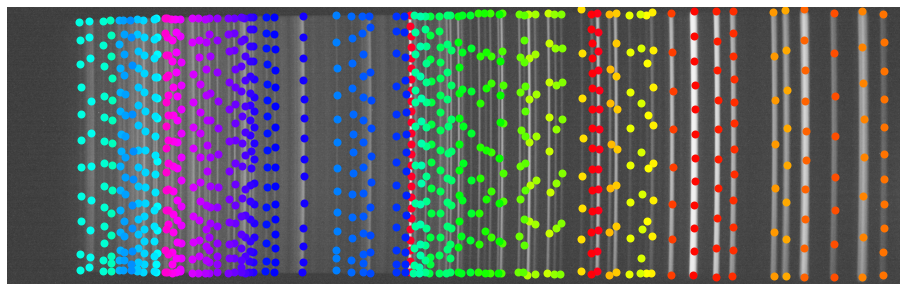

In [8]:
# Initial datasets, draw
im = skimage.io.imread("./test.png")
filepath = "./test.geojson"
mls = geopandas.GeoDataFrame.from_file(filepath).geometry.values
lines = [np.array([c for c in l.coords]) for l in mls]
nb_iso_lines = len(lines)
xss = [l[:,0] for l in lines]
yss = [l[:,1] for l in lines]
cm = plt.get_cmap('gist_rainbow')
colors = [cm(1.*i/nb_iso_lines) for i in range(nb_iso_lines)]
fig, ax = plt.subplots(1,figsize=(16,9))
ax.imshow(im)
ax.axis('off')
for xs, ys, color in zip(xss, yss, colors):
    ax.scatter(xs,ys, color=color)


(0.0, 553.0)

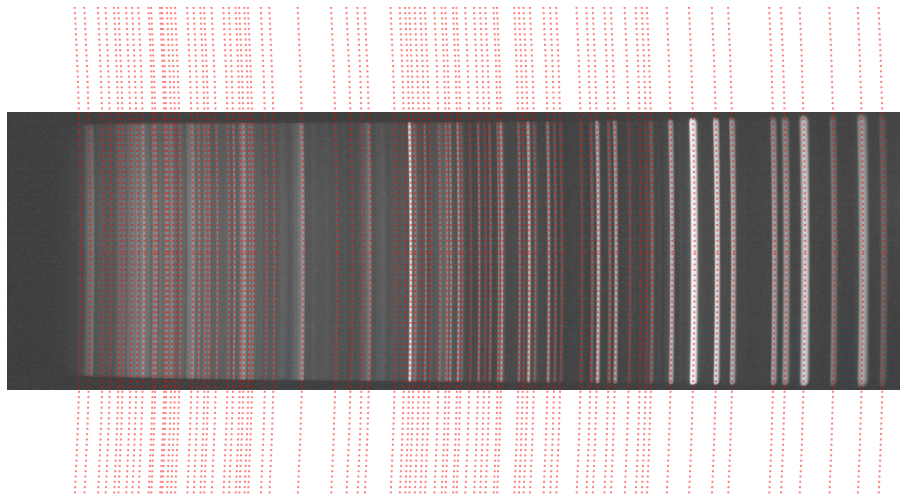

In [37]:
features = []
radii = []
for index, (xs, ys) in enumerate(zip(xss, yss)):
    M = np.vstack((xs, ys)).T
    M,y = get_polynomial_features_with_holes_same_center_diff_radii(M, nb_holes=len(xss), index=index)
    features.append(M)
    radii.append(y)

# Now perform global optimization
M = np.concatenate(tuple(features), axis=0)
y = np.concatenate(tuple(radii), axis=0)
c_cand, r_cand = estimate_non_centered_ellipsoid_isolines(M, y, nb_isoline=len(xss))

#print(c_cand.flatten().shape)
#print(r_cand.flatten().shape)
fig, ax = plt.subplots(1,figsize=(16,9))
ax.imshow(im)
ax.axis('off')

for r in r_cand:
    draw_ellipse_contour(np.identity(2),c=c_cand,r=r,fig=fig,ax=ax,method='parametrized', color='r')

ax.set_xlim(left=0, right=im.shape[1])
ax.set_ylim(bottom=0, top=im.shape[0])

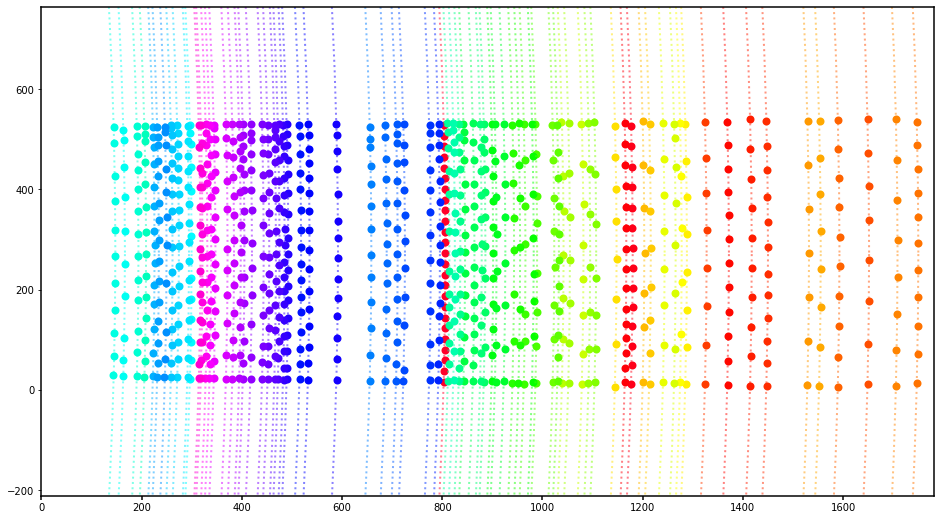

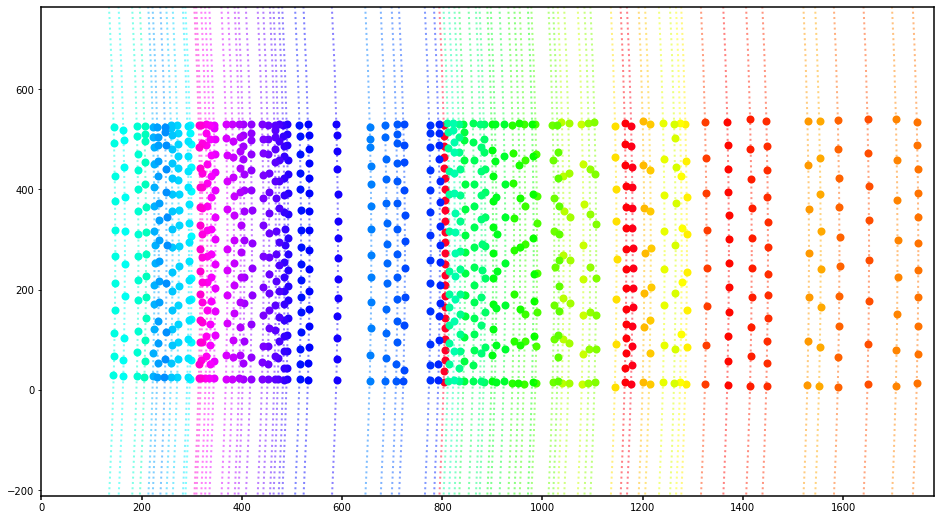

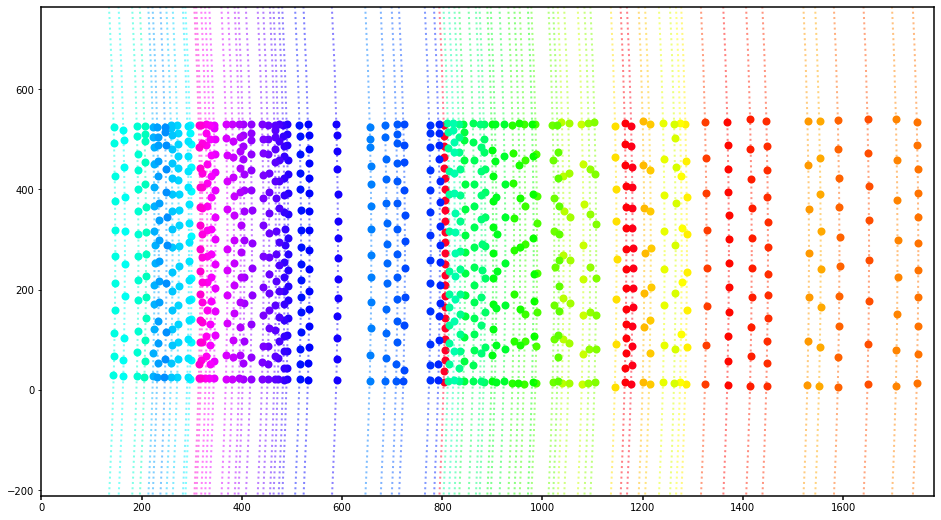

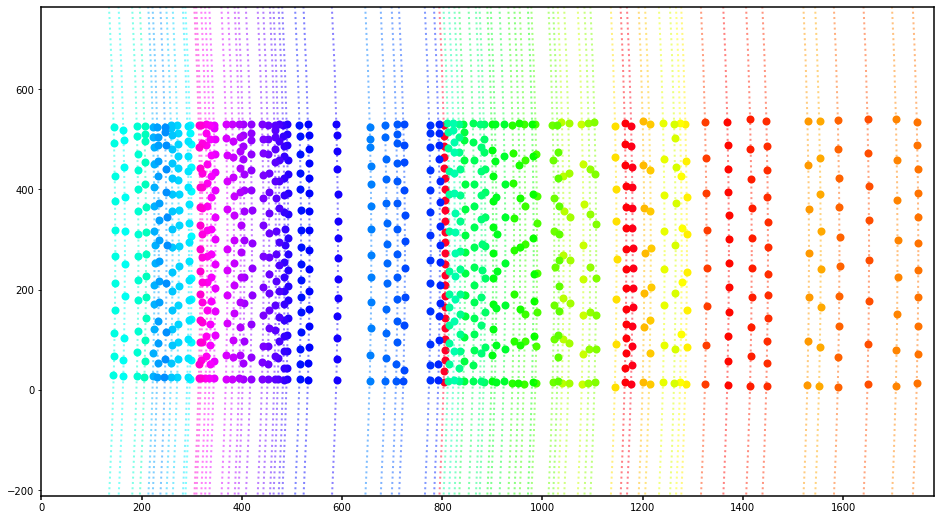

In [38]:
weights = np.ones(len(xss))
for iter in range(4):
    features = []
    radii = []
    # Now reweight if needed
    for index, (xs, ys) in enumerate(zip(xss, yss)):
        M = np.vstack((xs, ys)).T
        M,rad = get_polynomial_features_with_holes_same_center_diff_radii(M, nb_holes=len(xss), index=index)
        M, rad = M*weights[index], rad*weights[index]
        features.append(M)
        radii.append(rad)
    # Now perform global optimization
    M = np.concatenate(tuple(features), axis=0)
    y = np.concatenate(tuple(radii), axis=0)
    c_cand, r_cand = estimate_non_centered_ellipsoid_isolines(M, y, nb_isoline=len(xss))
    # Update weights
    weights = 1/np.array(r_cand)
    # Show results
    cm = plt.get_cmap('gist_rainbow')
    colors = [cm(1.*i/nb_iso_lines) for i in range(nb_iso_lines)]
    fig, ax = plt.subplots(1,figsize=(16,9))
    ax.scatter(c_cand[0], c_cand[1], color='r', marker='x')
    for xs, ys, r, color in zip(xss, yss, r_cand, colors):
        ax.scatter(xs,ys, color=color)
        draw_ellipse_contour(np.identity(2), c_cand,r, ax=ax,method='parametrized', color=color)
    ax.set_xlim(left=0, right=im.shape[1])
    ax.set_ylim(bottom=0, top=im.shape[0])
true_c_cand = c_cand

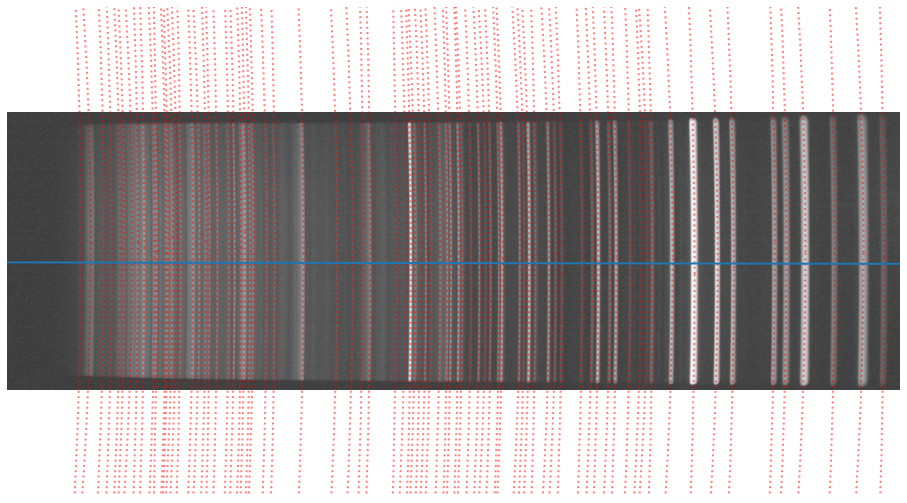

In [11]:
# Now lets try the approache where all centers are differents
c_cands=[]
r_cands=[]
for _, (xs, ys) in enumerate(zip(xss, yss)):
    M = np.vstack((xs, ys)).T
    M,y = get_polynomial_features_with_holes_same_center_diff_radii(M, nb_holes=1, index=0)
    c_cand, r_cand = estimate_non_centered_ellipsoid_isolines(M, y, nb_isoline=1)
    c_cands.append(c_cand)
    r_cands.append(r_cand)

# For fun, we'd also like to perform regression on the centers
from sklearn.linear_model import LinearRegression
X = np.array([i[0] for i in c_cands]).reshape(-1,1)
y = np.array([i[1] for i in c_cands])
reg = LinearRegression().fit(X, y)

# Draw results
fig, ax = plt.subplots(1,figsize=(16,9))
ax.imshow(im)
ax.axis('off')
for c, r in zip(c_cands, r_cands):
    draw_ellipse_contour(np.identity(2),c=c,r=r,fig=fig,ax=ax,method='parametrized', color='r')

ax.set_xlim(left=0, right=im.shape[1])
ax.set_ylim(bottom=0, top=im.shape[0])
#Trace line that goes through center
ax.plot([0, im.shape[1]], [reg.predict(np.array(0).reshape(-1,1)), reg.predict(np.array(im.shape[1]).reshape(-1,1))])
    

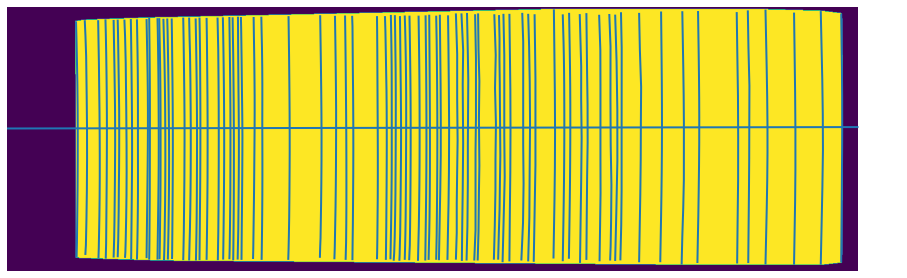

In [44]:
#Some image manipulation
import rasterio.features
from skimage.morphology import convex_hull_image
from geopandas import GeoDataFrame
mmls = MultiLineString(mls.tolist())
cull = mmls.convex_hull
mask = rasterio.features.rasterize(shapes=[cull], out_shape=im.shape[:2], all_touched=True)
#now dilate the mask
#l_mask = skimage.morphology.binary_dilation( l_mask,
#           selem=skimage.morphology.disk(radius=2))
#mask = convex_hull_image(mask)
fig, ax = plt.subplots(1, figsize=(16,9))
ax.imshow(mask)
ax.axis('off')
GeoDataFrame({"geometry":mmls}).plot(ax=ax)
ax.plot([0, im.shape[1]], [reg.predict(np.array(0).reshape(-1,1)), reg.predict(np.array(im.shape[1]).reshape(-1,1))])

In [48]:
# First, define smallest and largest values for lambda axe
center = Point(true_c_cand)
minl = center.distance(cull)
maxl = center.hausdorff_distance(cull)
nz = np.nonzero(mask)[0]
nb_sample = nz.max()-nz.min()+1
print(minl,maxl,nb_sample)

def lambda_to_index(dist):
    return int(np.round(((dist-minl)/(maxl-minl))*nb_sample-1))

histo = np.zeros(nb_sample-1)
weight = np.zeros(nb_sample-1)

for x in range(im.shape[1]):
    for y in range(im.shape[0]):
        if mask[y,x]:
            d = center.distance(Point((x,y)))
            index = lambda_to_index(d)
            histo[index]+=im[y,x]
            weight[index]+=im[y,x]
# Ok now, finally draw 1D profile from those data
plt.plot(histo)

9473.915589656606 11080.540463972342 536


ValueError: setting an array element with a sequence.